In [1]:
!pip install -qq transformers
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
import transformers
import torch
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader
from utils import TweetsDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
tokenizer = transformers.AutoTokenizer.from_pretrained("bertin-project/bertin-roberta-base-spanish")
model = transformers.RobertaForSequenceClassification.from_pretrained("bertin-project/bertin-roberta-base-spanish", num_labels=4, problem_type="multi_label_classification")
df_train = pd.read_csv("../../data/procesed.csv")

Some weights of the model checkpoint at bertin-project/bertin-roberta-base-spanish were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at bertin-project/bertin-roberta-base-spanish and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'clas

In [3]:
df_train, df_valid = TweetsDataset.split_test_val(df_train)
train_data_loader = TweetsDataset.create_data_loader(df_train, tokenizer)
valid_data_loader = TweetsDataset.create_data_loader(df_valid, tokenizer)

In [4]:
model = model.to(device)
EPOCHS = 8
optimizer = torch.optim.AdamW(model.parameters(), lr= 5e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [5]:
from utils import Model
history1 = Model.train(EPOCHS, model, train_data_loader, optimizer, device, scheduler, len(df_train), len(df_valid), valid_data_loader)

Epoch 1/8
----------
Train loss: 0.538 Accuracy: 0.356
Validation loss 0.534 Accuracy: 0.364 F1 score: 0.364

Epoch 2/8
----------


KeyboardInterrupt: 

In [7]:
torch.save(model.state_dict(), 'roberta_base_spanish.bin')

## Prueba del modelo

In [ ]:
# Test 
from utils import Results, Model
model = transformers.XLMRobertaForSequenceClassification.from_pretrained("bertin-project/bertin-roberta-base-spanish", num_labels=4, problem_type="multi_label_classification")
model.to(device)
model.load_state_dict(torch.load('roberta_base_spanish.bin'))
df_test = pd.read_csv('../../data/development_test.csv')
df_test = pd.DataFrame({
    "tweets": df_test["tweet"],
    "labels": df_test["ideology_multiclass"].map({'moderate_left': 0, 'moderate_right': 1, "left": 2, "right": 3})
})

test_data_loader = TweetsDataset.create_data_loader(df_test, tokenizer)
acc, loss, f1 = Model.test(model, test_data_loader, device, len(df_test))
Results.add_result("roberta", "ideology-multiclass", acc, loss, f1)

In [4]:
import torch.nn.functional as F
import sys

def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for i,d in enumerate(data_loader):
        print("Entrenando " + "."*(i%4), end="\r")
        loss, logits = model(
            input_ids=d["input_ids"].to(device),
            attention_mask=d["attention_mask"].to(device),
            labels=F.one_hot(d['labels'].to(device), num_classes=4).float(),
            return_dict=False
        )
        logits = logits.detach().cpu().numpy()
        label_ids = d['labels'].cpu().flatten().numpy()
        preds = np.argmax(logits, axis=1).flatten()
        targ = d['labels'].numpy()
        correct_predictions += np.sum(preds==targ)
        losses.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        sys.stdout.write("\033[K")
    return correct_predictions / n_examples, np.mean(losses)

def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            loss, logits = model(
                input_ids = d["input_ids"].to(device),
                attention_mask = d["attention_mask"].to(device),
                labels = F.one_hot(d['labels'].to(device), num_classes=4).float(),
                return_dict=False
            )
            logits = logits.detach().cpu().numpy()
            labels_ids = d['labels'].cpu().flatten().numpy()
            preds = np.argmax(logits, axis=1).flatten()
            targ = d['labels'].numpy()
            correct_predictions += np.sum(preds==targ)
            losses.append(loss.item())
        return correct_predictions / n_examples, np.mean(losses)

In [6]:
# Entrenamiento 
from collections import defaultdict
history = defaultdict(list)
best_acc = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-'*10)   
    train_acc, train_loss = train_epoch(model, train_data_loader, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} Accuracy {train_acc}')
    val_acc, val_loss = eval_model(model, valid_data_loader, device, len(df_valid))
    print(f'Val loss {val_loss} Accuracy {val_acc}')
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_acc:
#         torch.save(model.state_dict(), 'best_model_state_a5.bin')
        best_acc = val_acc

Epoch 1/8
----------
Train loss 0.5251490030802932 Accuracy 0.3941176470588235
Val loss 0.5178151634004381 Accuracy 0.44166666666666665

Epoch 2/8
----------
Train loss 0.47006507921063045 Accuracy 0.5072712418300653
Val loss 0.5488456907095732 Accuracy 0.449537037037037

Epoch 3/8
----------
Train loss 0.36318375767251243 Accuracy 0.6558006535947712
Val loss 0.579052103890313 Accuracy 0.4638888888888889

Epoch 4/8
----------
Train loss 0.2363320443852275 Accuracy 0.8116830065359477
Val loss 0.7612768793547595 Accuracy 0.46944444444444444

Epoch 5/8
----------
Train loss 0.14805557708091596 Accuracy 0.905718954248366
Val loss 0.9605343659718831 Accuracy 0.4759259259259259

Epoch 6/8
----------
Train loss 0.0872845443154326 Accuracy 0.956045751633987
Val loss 1.1376878162225088 Accuracy 0.47638888888888886

Epoch 7/8
----------
Train loss 0.04963176132368496 Accuracy 0.9785130718954248
Val loss 1.1932741706018095 Accuracy 0.47453703703703703

Epoch 8/8
----------
Train loss 0.0283352191

Text(0.5, 0.98, 'Precisión y pérdida de entrenamiento y validación (Roberta)')

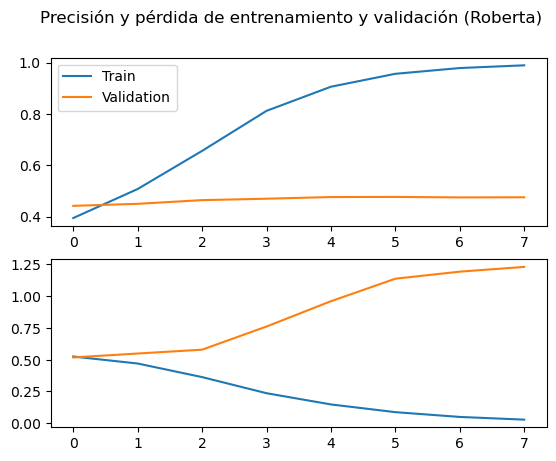

In [42]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(history["train_acc"], label = "Train")
ax1.plot(history["val_acc"], label="Validation")
ax2.plot(history["train_loss"], label="Train")
ax2.plot(history["val_loss"], label="Validation")
ax1.legend()
fig.suptitle('Precisión y pérdida de entrenamiento y validación (Roberta)')

In [8]:
# Test 
model.to(device)
model.load_state_dict(torch.load('./bertin-base-v1.bin', map_location=torch.device(device)))
model.eval()

df_test = pd.read_csv("../../data/development_test.csv")
df_test = pd.DataFrame({
    "tweets": df_test["tweet"],
    "labels": df_test["ideology_multiclass"].map({'moderate_left': 0, 'moderate_right': 1, "left": 2, "right": 3})
})
test_data_loader = TweetsDataset.create_data_loader(df_test, tokenizer)

In [9]:
from utils import Model, Results
acc, loss, f1 = Model.test(model, test_data_loader, device, len(df_test))
Results.add_result("bertin-base", "ideology-multiclass", acc, loss, f1)

Test loss: 0.827 Accuracy: 0.392


In [13]:
results = pd.read_csv("../results.csv")
results = results.append(pd.DataFrame({
     "model": "bertin-base",
     "class": "ideology-multiclass",
     "loss": loss,
     "f1score": f1,
     "accuracy": acc 
}, index=[0]))
results.to_csv("../results.csv")

C:\Users\javid\AppData\Local\Temp\ipykernel_9428\3982103931.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame({


In [ ]:
Results.add_result("bertin-base", "ideology-multiclass", acc, loss, f1)